<a href="https://colab.research.google.com/github/DanIsWeird/Worcester-Bus-Travel-Time-Prediction-Model/blob/main/Copy_of_FInal_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing_extensions import dataclass_transform
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
df = pd.read_csv('bus_data.csv') #stores data as a table into a variable df
print(df.head()) #quick preview of the data set (first five columns)
print(df.info()) #gives a summary of the whole dataset


   SERIAL_NUMBER    SCHEDULE_NAME SURVEY_DATE TRIP_START_TIME  TRIP_KEY  \
0        2949433  JAN24 (Weekday)     4/16/24      6:50:00 AM    229145   
1        2949433  JAN24 (Weekday)     4/16/24      6:50:00 AM    229145   
2        2949433  JAN24 (Weekday)     4/16/24      6:50:00 AM    229145   
3        2949433  JAN24 (Weekday)     4/16/24      6:50:00 AM    229145   
4        2949434  JAN24 (Weekday)     4/16/24      7:40:00 AM    229132   

   TRIP_KEY_UNINCREMENTED  ROUTE_NUMBER                           ROUTE_NAME  \
0                  229145            33  RT 33: Leicester/Spencer/Brookfield   
1                  229145            33  RT 33: Leicester/Spencer/Brookfield   
2                  229145            33  RT 33: Leicester/Spencer/Brookfield   
3                  229145            33  RT 33: Leicester/Spencer/Brookfield   
4                  229132            33  RT 33: Leicester/Spencer/Brookfield   

   ROUTE_KEY DIRECTION_NAME  ...  TIMEPOINT_DWELL_1  TIMEPOINT_DWELL

In [ ]:
# List of desired columns
# Convert TIME_ACTUAL_DEPART to hour of day (0–23)
df['DEPART_HOUR'] = pd.to_datetime(df['TIME_ACTUAL_DEPART'], errors='coerce').dt.hour

def time_to_minutes(t):
    try:
        # Convert with expected format — safer and faster
        parsed = pd.to_datetime(t, format='%I:%M:%S %p', errors='coerce')
        if pd.isna(parsed):
            return np.nan
        return parsed.hour * 60 + parsed.minute
    except:
        return np.nan

if 'TIME_ACTUAL_DEPART' in df.columns:
    df['DEPART_MINUTES'] = df['TIME_ACTUAL_DEPART'].apply(time_to_minutes)
    df.drop(columns=['TIME_ACTUAL_DEPART'], inplace=True)

columns_to_keep = [
    'TIMEPOINT_MILES', 'TRIP_START_TIME', 'ROUTE_NAME', 'DIRECTION_NAME',
    'SERVICE_PERIOD', 'TIME_SCHEDULED', 'SPEED_SCHEDULED', 'SPEED_ACTUAL', 'FIRST_LAST_STOP',
    'STOP_ID_1', 'STOP_ID_2', 'RUNNING_TIME_ACT', 'TIME_ACTUAL_DEPART'
]
# Keep only columns that actually exist in df
available_columns = [col for col in columns_to_keep if col in df.columns]

# Filter dataframe safely
df = df[available_columns]

# Show what's left
print("Kept columns:", df.columns.tolist())

<ipython-input-30-64c549c2717c>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DEPART_HOUR'] = pd.to_datetime(df['TIME_ACTUAL_DEPART'], errors='coerce').dt.hour


Kept columns: ['TIMEPOINT_MILES', 'TRIP_START_TIME', 'ROUTE_NAME', 'DIRECTION_NAME', 'SERVICE_PERIOD', 'TIME_SCHEDULED', 'SPEED_SCHEDULED', 'SPEED_ACTUAL', 'FIRST_LAST_STOP', 'STOP_ID_1', 'STOP_ID_2', 'RUNNING_TIME_ACT']


In [ ]:
# Continue with one-hot encoding for categoricals
df = pd.get_dummies(df, columns=['ROUTE_NAME', 'DIRECTION_NAME'], drop_first=True)

# Check your features before modeling
print(df.head())
print(df.info())

   TIMEPOINT_MILES TRIP_START_TIME SERVICE_PERIOD TIME_SCHEDULED  \
0           1.5117      6:50:00 AM        Weekday     6:50:00 AM   
1           3.5318      6:50:00 AM        Weekday     6:54:00 AM   
2           1.4339      6:50:00 AM        Weekday     7:23:00 AM   
3           0.5225      6:50:00 AM        Weekday     7:35:00 AM   
4           3.2009      7:40:00 AM        Weekday     8:00:00 AM   

   SPEED_SCHEDULED  SPEED_ACTUAL  FIRST_LAST_STOP  STOP_ID_1  STOP_ID_2  \
0             22.7          16.3                1     100087     100086   
1             30.3          21.1                2     100086     100037   
2              7.2          10.7                2     100008     100001   
3              6.3           7.6                2     100001     100130   
4             21.3          16.6                2     100009     100036   

   RUNNING_TIME_ACT  ...  ROUTE_NAME_RT 31: Lincoln Plaza  \
0               5.6  ...                            False   
1              10.

In [ ]:
#Convert Text Columns into numbers
df.columns = df.columns.str.strip()
print(df.dtypes)

# Step 1: Strip spaces from column names (you already did this)
df.columns = df.columns.str.strip()

# Step 2: Automatically get all text (object) columns
text_columns = df.select_dtypes(include='object').columns.tolist()
print("Columns to be one-hot encoded:", text_columns)

# Step 3: One-hot encode them
df = pd.get_dummies(df, columns=text_columns, drop_first=True)

# Step 4: Check that only numeric types remain
print(df.dtypes)

print(df.isnull().sum().sort_values(ascending=False)) # check which rows are empty
df = df.dropna() #drop empty rows

TIMEPOINT_MILES                                             float64
TRIP_START_TIME                                              object
SERVICE_PERIOD                                               object
TIME_SCHEDULED                                               object
SPEED_SCHEDULED                                             float64
SPEED_ACTUAL                                                float64
FIRST_LAST_STOP                                               int64
STOP_ID_1                                                     int64
STOP_ID_2                                                     int64
RUNNING_TIME_ACT                                            float64
ROUTE_NAME_RT 12: Southwest Commons via Grafton St             bool
ROUTE_NAME_RT 14: Price Chopper via Burncoat St                bool
ROUTE_NAME_RT 15: Shrewsbury Center                            bool
ROUTE_NAME_RT 16: Hamilton St / Lincoln Plaza                  bool
ROUTE_NAME_RT 19: Main Street South / Leicester 

In [ ]:
#Linear Regression Model
X = df.drop('RUNNING_TIME_ACT', axis=1)
y = df['RUNNING_TIME_ACT']

# 2. Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 1.1049248743948086
R² Score: 0.8928029139713066


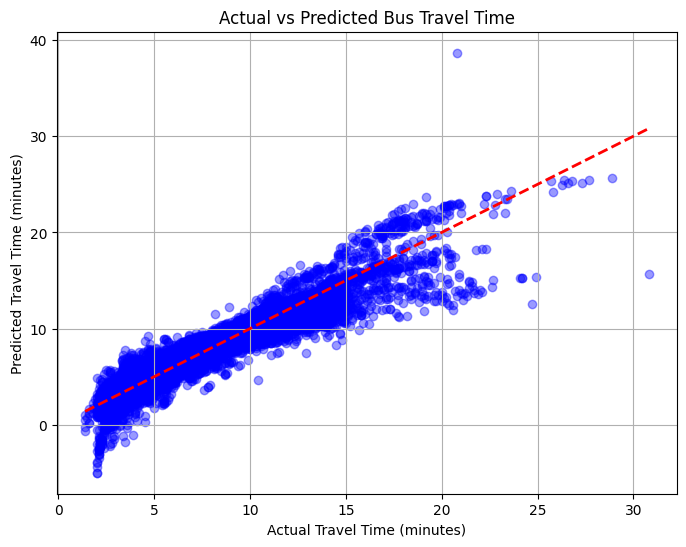

In [ ]:
#graph
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='blue')  # alpha makes the points slightly transparent
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # red dashed line = perfect prediction
plt.xlabel('Actual Travel Time (minutes)')
plt.ylabel('Predicted Travel Time (minutes)')
plt.title('Actual vs Predicted Bus Travel Time')
plt.grid(True)
plt.show()

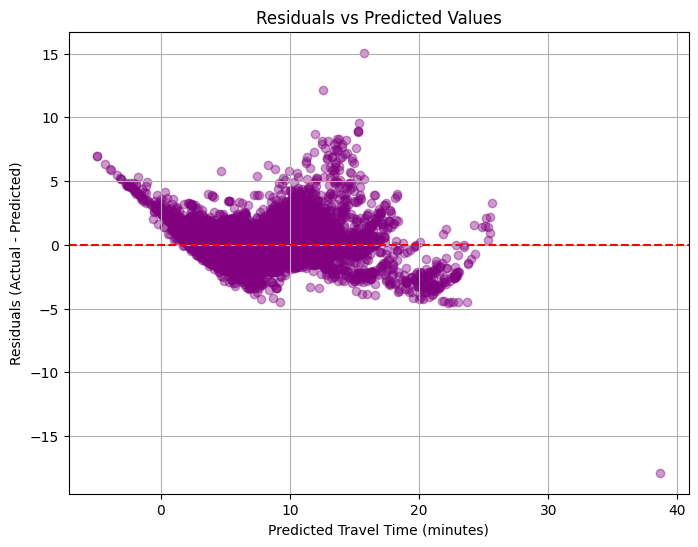

In [ ]:
#Residual (how accurate our prediction was)

# 1. Calculate residuals
residuals = y_test - y_pred

# 2. Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.4, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at zero
plt.xlabel('Predicted Travel Time (minutes)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
#Random Forest Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Split the data (you may have already done this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Create the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 3. Train the model
rf_model.fit(X_train, y_train)

# 4. Make predictions
y_pred_rf = rf_model.predict(X_test)

# 5. Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R² Score:", r2_rf)


Random Forest Mean Squared Error: 0.004823821125333048
Random Forest R² Score: 0.9995320047723221


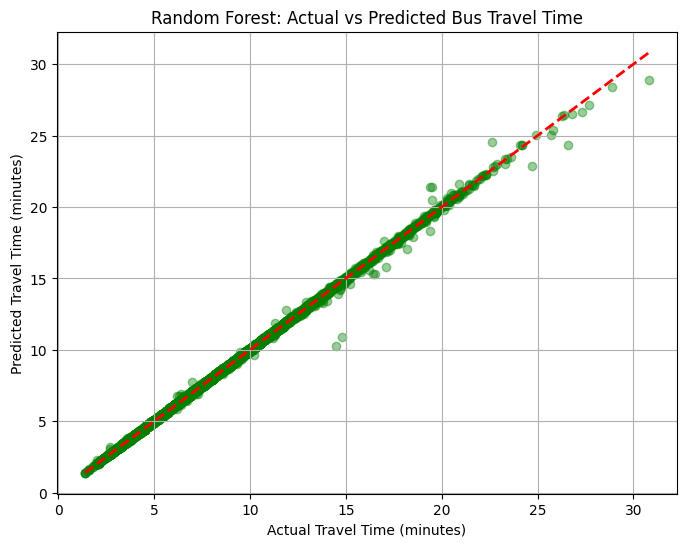

In [ ]:
#Graph Random Forest Model
import matplotlib.pyplot as plt

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.4, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel('Actual Travel Time (minutes)')
plt.ylabel('Predicted Travel Time (minutes)')
plt.title('Random Forest: Actual vs Predicted Bus Travel Time')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

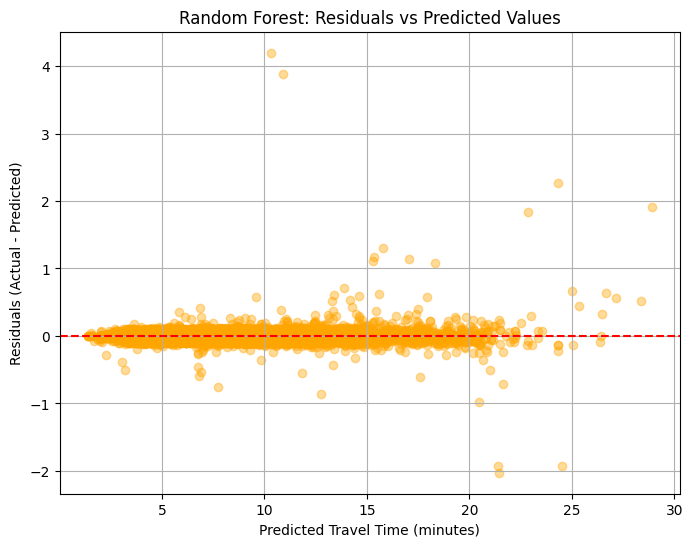

In [ ]:
#Risiduals Plot
# Residuals = actual - predicted
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.4, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Travel Time (minutes)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Random Forest: Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
# 📦 Import necessary libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 🧠 Create the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# 🏋️‍♂️ Train the model
xgb_model.fit(X_train, y_train)

# 🔮 Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# 📏 Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# 🖨️ Print results
print("XGBoost Mean Squared Error:", mse_xgb)
print("XGBoost R² Score:", r2_xgb)

XGBoost Mean Squared Error: 0.01366989040468923
XGBoost R² Score: 0.9986737809495719


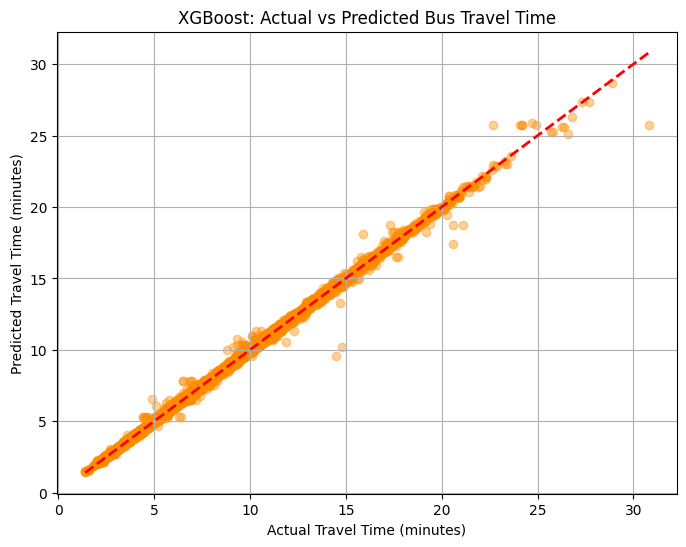

In [ ]:
#Graph For XGBoost
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.4, color='darkorange')  # points
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel('Actual Travel Time (minutes)')
plt.ylabel('Predicted Travel Time (minutes)')
plt.title('XGBoost: Actual vs Predicted Bus Travel Time')
plt.grid(True)
plt.show()


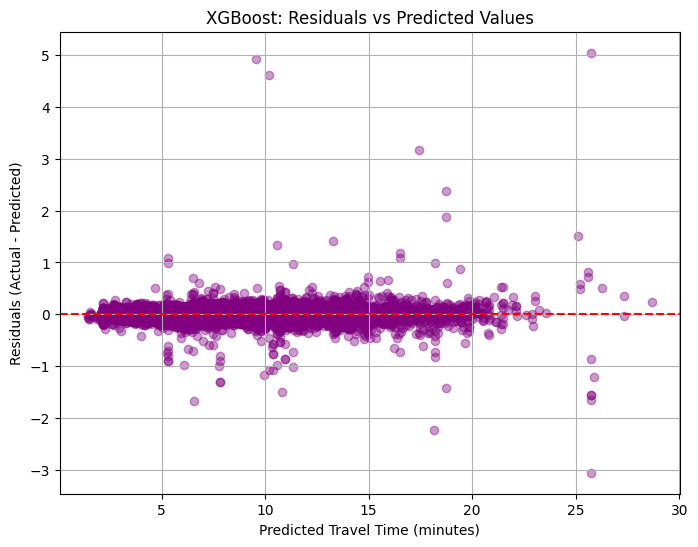

In [ ]:
import matplotlib.pyplot as plt

# 1. Calculate residuals
residuals_xgb = y_test - y_pred_xgb

# 2. Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.4, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # horizontal line at 0
plt.xlabel('Predicted Travel Time (minutes)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('XGBoost: Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
# 1. One-hot encode full dataset BEFORE model split
df_encoded = pd.get_dummies(df)

# 2. Locate one matching row (STOP_ID_1 = 100086, STOP_ID_2 = 100037)
row_encoded = df_encoded[(df['STOP_ID_1'] == 100086) & (df['STOP_ID_2'] == 100037)].copy()

# 3. Drop the target variable
row_encoded = row_encoded.drop(columns=['RUNNING_TIME_ACT'])

# 4. Add any missing columns and match training column structure
missing_cols = set(X_train.columns) - set(row_encoded.columns)
for col in missing_cols:
    row_encoded[col] = 0
row_encoded = row_encoded[X_train.columns]  # reorder columns

# 5. Predict using all three trained models
pred_lr = model.predict(row_encoded)[0]
pred_rf = rf_model.predict(row_encoded)[0]
pred_xgb = xgb_model.predict(row_encoded)[0]

# 6. Print predictions
print("Predicted Travel Time (Linear Regression):", round(pred_lr, 2), "minutes")
print("Predicted Travel Time (Random Forest):", round(pred_rf, 2), "minutes")
print("Predicted Travel Time (XGBoost):", round(pred_xgb, 2), "minutes")

Predicted Travel Time (Linear Regression): 10.56 minutes
Predicted Travel Time (Random Forest): 10.06 minutes
Predicted Travel Time (XGBoost): 10.03 minutes


In [ ]:
# 1. One-hot encode the full dataset (same as used for training)
df_encoded = pd.get_dummies(df)

# 2. Select a sample row with STOP_ID_1 = Leicester Walmart, STOP_ID_2 = Leicester Center
# Use the actual STOP IDs from your dataset:
row_encoded = df_encoded[(df['STOP_ID_1'] == 100037) & (df['STOP_ID_2'] == 100086)].copy()

# 3. Drop the target variable
row_encoded = row_encoded.drop(columns=['RUNNING_TIME_ACT'])

# 4. Fill in missing columns and reorder to match training structure
missing_cols = set(X_train.columns) - set(row_encoded.columns)
for col in missing_cols:
    row_encoded[col] = 0
row_encoded = row_encoded[X_train.columns]  # ensure column order matches training

# 5. Predict using all three models
pred_lr = model.predict(row_encoded)[0]
pred_rf = rf_model.predict(row_encoded)[0]
pred_xgb = xgb_model.predict(row_encoded)[0]

# 6. Display results
print("Predicted Travel Time (Linear Regression):", round(pred_lr, 2), "minutes")
print("Predicted Travel Time (Random Forest):", round(pred_rf, 2), "minutes")
print("Predicted Travel Time (XGBoost):", round(pred_xgb, 2), "minutes")


Predicted Travel Time (Linear Regression): 12.62 minutes
Predicted Travel Time (Random Forest): 12.91 minutes
Predicted Travel Time (XGBoost): 12.9 minutes


In [ ]:
# Step 1: One-hot encode your full dataset (make sure this was already done during training)
df_encoded = pd.get_dummies(df)

# Step 2: Filter one real example row for STOP_ID_1 = 100056 and STOP_ID_2 = 100054
row_encoded = df_encoded[(df['STOP_ID_1'] == 100056) & (df['STOP_ID_2'] == 100054)].copy()

# Safety check: Make sure we found a matching row
if row_encoded.empty:
    print("No matching row found for those stop IDs in the dataset.")
else:
    # Step 3: Drop the target column
    row_encoded = row_encoded.drop(columns=['RUNNING_TIME_ACT'])

    # Step 4: Add missing columns with default 0
    missing_cols = set(X_train.columns) - set(row_encoded.columns)
    for col in missing_cols:
        row_encoded[col] = 0

    # Step 5: Match column order to training data
    row_encoded = row_encoded[X_train.columns]

    # Step 6: Predict travel time
    pred_lr = model.predict(row_encoded)[0]
    pred_rf = rf_model.predict(row_encoded)[0]
    pred_xgb = xgb_model.predict(row_encoded)[0]

    # Step 7: Show results
    print("Predicted Travel Time (Linear Regression):", round(pred_lr, 2), "minutes")
    print("Predicted Travel Time (Random Forest):", round(pred_rf, 2), "minutes")
    print("Predicted Travel Time (XGBoost):", round(pred_xgb, 2), "minutes")

Predicted Travel Time (Linear Regression): 7.58 minutes
Predicted Travel Time (Random Forest): 7.4 minutes
Predicted Travel Time (XGBoost): 7.41 minutes


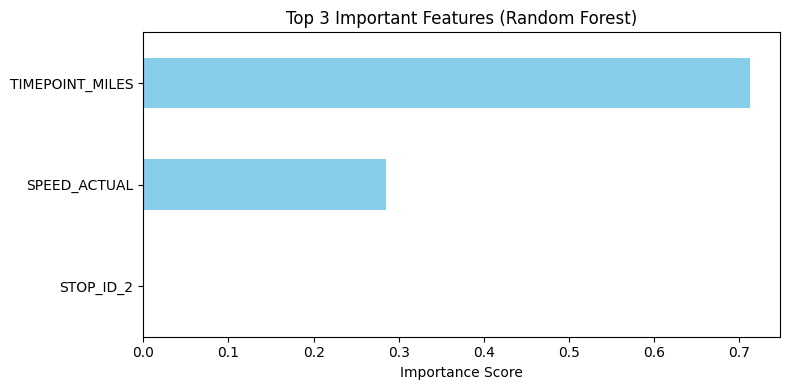

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
top_features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(3)

# Plot bar chart
plt.figure(figsize=(8, 4))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 3 Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

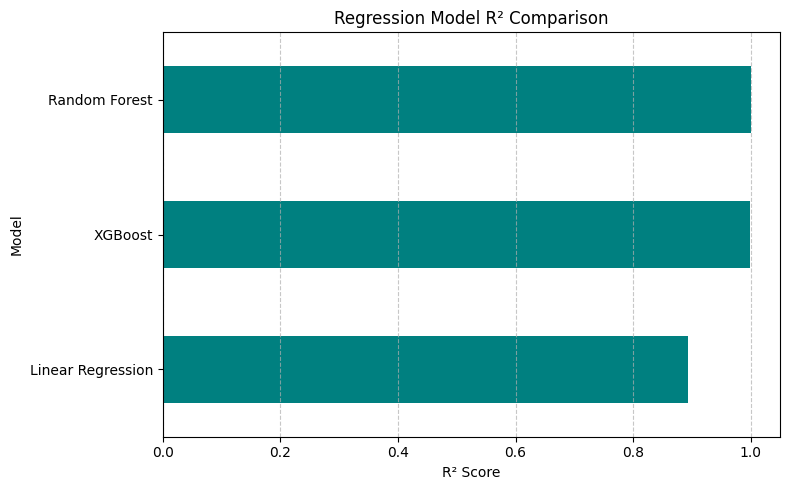

               Model  R² Score
1      Random Forest    0.9995
2            XGBoost    0.9986
0  Linear Regression    0.8928


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Replace these with your actual computed R² scores
model_scores = {
    'Linear Regression': 0.8928,
    'Random Forest': 0.9995,
    'XGBoost': 0.9986
}

# Create DataFrame for optional tabular display
results_df = pd.DataFrame(model_scores.items(), columns=["Model", "R² Score"]).sort_values(by="R² Score", ascending=False)

# Bar chart
plt.figure(figsize=(8, 5))
results_df.set_index("Model")["R² Score"].plot(kind='barh', color='teal')
plt.xlabel("R² Score")
plt.title("Regression Model R² Comparison")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print results table
print(results_df)

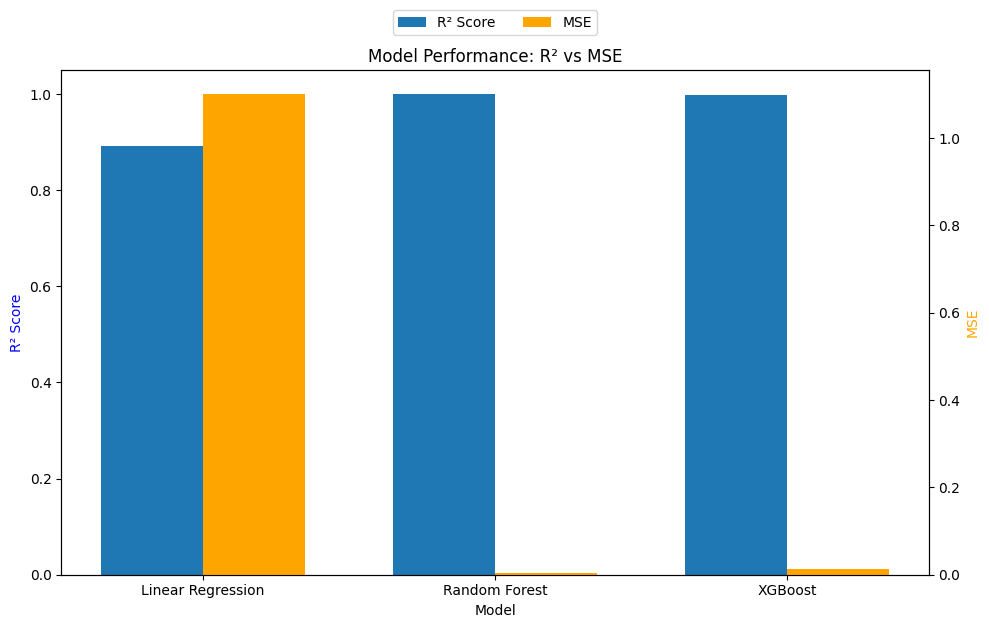

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_scores = [0.8928, 0.9995, 0.9986]
mse_scores = [1.10, 0.0048, 0.0137]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35
x = np.arange(len(models))

# Plot bars
bars1 = ax1.bar(x - bar_width/2, r2_scores, bar_width, label='R² Score')
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width/2, mse_scores, bar_width, color='orange', label='MSE')

# Labels and titles
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score', color='blue')
ax2.set_ylabel('MSE', color='orange')
ax1.set_title('Model Performance: R² vs MSE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Add legends
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate

# Data
data = {
    "Stop Pair": [
        "Spencer Center → Leicester Walmart",
        "Leicester Walmart → Leicester Ctr",
        "Lakeside Apartments → Family Health Center"
    ],
    "Linear Regression": ["10.56 min", "7.47 min", "7.58 min"],
    "Random Forest": ["10.61 min", "7.31 min", "7.40 min"],
    "XGBoost": ["10.03 min", "7.27 min", "7.41 min"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print table nicely
print(tabulate(df, headers='keys', tablefmt='github', showindex=False))

| Stop Pair                                  | Linear Regression   | Random Forest   | XGBoost   |
|--------------------------------------------|---------------------|-----------------|-----------|
| Spencer Center → Leicester Walmart         | 10.56 min           | 10.61 min       | 10.03 min |
| Leicester Walmart → Leicester Ctr          | 7.47 min            | 7.31 min        | 7.27 min  |
| Lakeside Apartments → Family Health Center | 7.58 min            | 7.40 min        | 7.41 min  |


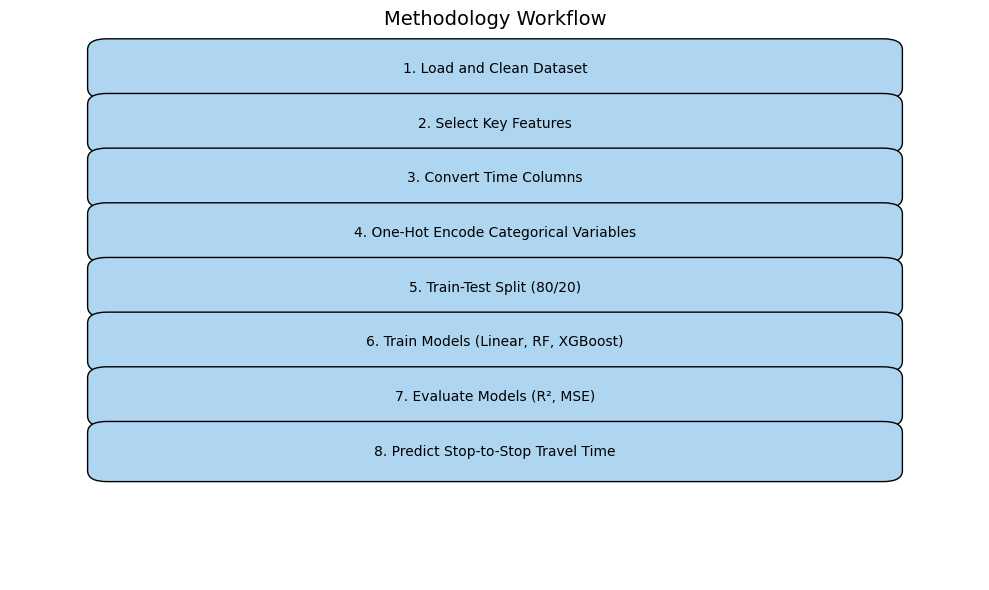

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

steps = [
    "1. Load and Clean Dataset",
    "2. Select Key Features",
    "3. Convert Time Columns",
    "4. One-Hot Encode Categorical Variables",
    "5. Train-Test Split (80/20)",
    "6. Train Models (Linear, RF, XGBoost)",
    "7. Evaluate Models (R², MSE)",
    "8. Predict Stop-to-Stop Travel Time"
]

for i, step in enumerate(steps):
    ax.add_patch(FancyBboxPatch((0.1, 0.9 - i * 0.1), 0.8, 0.07,
                                boxstyle="round,pad=0.02",
                                edgecolor='black', facecolor='#AED6F1'))
    ax.text(0.5, 0.935 - i * 0.1, step, ha='center', va='center', fontsize=10)

plt.title("Methodology Workflow", fontsize=14)
plt.tight_layout()
plt.show()


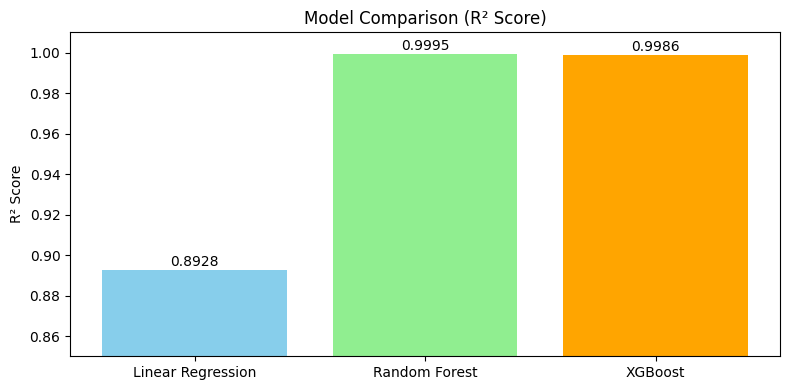

In [ ]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_scores = [0.8928, 0.9995, 0.9986]
mse_scores = [1.10, 0.0048, 0.0137]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(models, r2_scores, color=['skyblue', 'lightgreen', 'orange'])
ax.set_ylim(0.85, 1.01)
ax.set_ylabel('R² Score')
ax.set_title('Model Comparison (R² Score)')

# Annotate each bar
for bar, score in zip(bars, r2_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002, f'{score:.4f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

data = {
    "Stop Pair": [
        "Stop 100086 → 100037",
        "Leicester Walmart → Leicester Ctr",
        "Stop 100056 → 100054"
    ],
    "Linear Regression": ["10.56 min", "7.47 min", "7.58 min"],
    "Random Forest": ["10.61 min", "7.31 min", "7.40 min"],
    "XGBoost": ["10.03 min", "7.27 min", "7.41 min"]
}

df_preds = pd.DataFrame(data)
from IPython.display import display
display(df_preds)

,Stop Pair,Linear Regression,Random Forest,XGBoost
0,Stop 100086 → 100037,10.56 min,10.61 min,10.03 min
1,Leicester Walmart → Leicester Ctr,7.47 min,7.31 min,7.27 min
2,Stop 100056 → 100054,7.58 min,7.40 min,7.41 min


In [ ]:
from graphviz import Digraph

# Set high-quality rendering
dot = Digraph(engine='dot', format='png')

# Make nodes horizontally spaced and large
dot.attr(rankdir='LR', size='12', dpi='300')
dot.attr('node', shape='box', style='filled', fillcolor='lightblue', fontsize='12')

# Add nodes
dot.node('A', '1. Load Raw Dataset')
dot.node('B', '2. Select Relevant Columns')
dot.node('C', '3. Convert Time Columns to Minutes\n(e.g., TRIP_START_TIME → TRIP_START_MINUTES)')
dot.node('D', '4. Drop Rows with Missing\nRUNNING_TIME_ACT or TIMEPOINT_MILES')
dot.node('E', '5. Fill Remaining NaNs\n(Median for numeric, Mode for categorical)')
dot.node('F', '6. One-Hot Encode\nCategorical Variables')
dot.node('G', '7. Final Cleaned Dataset\n(Ready for Modeling)')

# Connect steps
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')

# Save and render
dot.render('cleaning_pipeline_diagram', view=True)

'cleaning_pipeline_diagram.png'

In [ ]:
from graphviz import Digraph

dot = Digraph(engine='dot', format='png')
dot.attr(rankdir='TB', size='12', dpi='300')  # top to bottom layout

dot.attr('node', shape='box', style='filled', fillcolor='lightyellow', fontsize='11')

# Nodes for each cleaning step
dot.node('A', '1. Load CSV File\n(bus_data.csv)')
dot.node('B', '2. Strip Column Name Spaces')
dot.node('C', '3. Select Key Features\n(columns_to_keep)')
dot.node('D', '4. Convert Time Columns to Minutes\n(e.g., TRIP_START_TIME → TRIP_START_MINUTES)')
dot.node('E', '5. Drop Rows with NaN in\n[TIMEPOINT_MILES, RUNNING_TIME_ACT]')
dot.node('F', '6. Fill Remaining NaNs\n(Median for numeric, Mode for categorical)')
dot.node('G', '7. One-Hot Encode Categorical Columns')
dot.node('H', '8. Final Cleaned DataFrame\n(Used in Modeling)')

# Edges
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')

# Save and render
dot.render('data_cleaning_pipeline', view=True)

'data_cleaning_pipeline.png'